In [ ]:
# 출처 : https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/

In [1]:
# DB접속
import os
from os import listdir
import cx_Oracle as oci
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# 그래프
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


In [2]:
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

### 1.데이터 불러오기

In [3]:
###############
# 1.데이터 불러오기 : 최근1년간, 방문회원  
#####

# query run
query1 = '''select unfy_mmb_no
            , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
            , coopco_cd
            , tot_sel_amt
            , to_char(reg_dtm, 'YY/MM/DD') as reg_dtm
            from mmbship.TP_TRSC_PTCL
            where unfy_mmb_no is not null 
            and tot_sel_amt > 0 
            and to_char(reg_dtm, 'YYYY') = '2021'
            and trsc_typ_cd in ( 'G40', '200', '300')
            union all

            --쿠폰 사용
            select A.unfy_mmb_no
            , '쿠폰사용' as trsc_typ_cd
            , U.coopco_cd
            , u.dc_tgt_amt as tot_sel_amt
            , to_char(A.reg_dtm, 'YY/MM/DD') as reg_dtm
            from mmbship.TPM_CPN_ISSU A, mmbship.TPM_CPN B, mmbship.TPM_CPN_use U
            where A.CPN_CD = B.cpn_cd 
            and cpn_st_cd ='2' 
            and A.CPN_issu_CD = U.CPN_issu_CD
            and coopco_cd in (7050, 7060)
            and to_char(A.reg_dtm, 'YYYY') = '2021'
        '''
df1_A = pd.read_sql(query1, con = conn )


In [4]:
df1_A['REG_DTM'] = pd.to_datetime(df1_A['REG_DTM'],format = '%y/%m/%d')
# df['REG_DTM'] = df['REG_DTM']
df1_A['UNFY_MMB_NO'] = df1_A['UNFY_MMB_NO'].astype(object)

In [5]:
df1_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246730 entries, 0 to 246729
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   UNFY_MMB_NO  246706 non-null  object        
 1   TRSC_TYP_CD  246730 non-null  object        
 2   COOPCO_CD    246730 non-null  object        
 3   TOT_SEL_AMT  246730 non-null  int64         
 4   REG_DTM      246730 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.4+ MB


In [6]:
df1_A.tail(2)

,UNFY_MMB_NO,TRSC_TYP_CD,COOPCO_CD,TOT_SEL_AMT,REG_DTM
246728,6499433.0,쿠폰사용,7050,45000,2021-12-23
246729,5216322.0,쿠폰사용,7050,30000,2021-12-27


In [10]:
# df1_A

In [7]:
df_sub = pd.pivot_table(df1_A, values='UNFY_MMB_NO', index=['COOPCO_CD'],columns=['TRSC_TYP_CD'],  aggfunc='count').fillna(0)

In [8]:
df_sub

TRSC_TYP_CD,기프트카드사용/사용취소,쿠폰사용,포인트 사용/사용취소,포인트 적립/적립취소
COOPCO_CD,,,,
7010,504.0,0.0,0.0,0.0
7020,5787.0,0.0,50870.0,67837.0
7030,50984.0,0.0,2833.0,16082.0
7040,1918.0,0.0,9255.0,35787.0
7050,1426.0,577.0,42.0,1635.0
7060,155.0,377.0,10.0,627.0


### 2.자료변환

![nn](https://cdn-images-1.medium.com/max/800/1*M9THB3FONFSF2lQHd-9cHg.png)

In [10]:
df = df1_A.copy()

In [16]:
# today_date = datetime(2021, 12, 31) # We have to set today date in order to calculate Recency metric
customer = df.groupby('UNFY_MMB_NO').agg({'REG_DTM': lambda x: x.min().month,
                                     'UNFY_MMB_NO': lambda num: num.count(), # Frequency calculation
                                     'TOT_SEL_AMT': lambda TotalPrice: TotalPrice.sum()}) # Monetary calculation

In [19]:
customer.columns = ['Start_Month', 'Frequency', 'TotalSales'] # Changing column names

In [20]:
customer.head()

,Start_Month,Frequency,TotalSales
UNFY_MMB_NO,,,
381692.0,5,7,332686
382749.0,9,1,7000
383331.0,2,5,74480
383516.0,1,5,92960
384101.0,4,1,42770


![nx](https://cdn-images-1.medium.com/max/800/1*vqZcIDGu64VPWWoQuUzUIw.png)

In [21]:
month = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep' 'Oct', 'Nov', 'Dec']
Monthly_CLV = []
Profit_margin = 0.05

for i in range(1,13):
    customer_m = customer[customer['Start_Month'] ==i]

    Average_sales = round(np.mean(customer_m['TotalSales']), 2) 
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round( (Average_sales * Purchase_freq / churn) * Profit_margin,2  )
    Monthly_CLV.append(CLV)


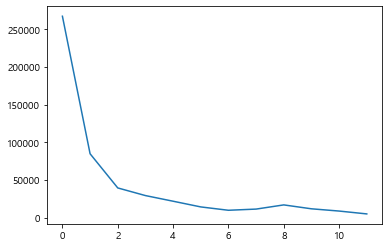

In [26]:
plt.plot(Monthly_CLV)